In [99]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from IPython.display import display
from sklearn.metrics import auc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [100]:
df = pd.read_csv('course_lead_scoring.csv')

In [101]:
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [102]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [103]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [104]:
df.lead_source = df.lead_source.fillna('NA')
df.industry = df.industry.fillna('NA')
df.annual_income = df.annual_income.fillna(0.0)
df.employment_status = df.employment_status.fillna('NA')
df.location = df.location.fillna('NA')

In [105]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [106]:
numerical  = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [107]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [108]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_test), len(df_val)

(876, 293, 293)

In [109]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [110]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [111]:
feature_auc_scores = {}

for feature in numerical:
    auc_score = roc_auc_score(y_train, df_train[feature])
    feature_auc_scores[feature] = auc_score

sorted_auc_scores = sorted(feature_auc_scores.items(), key=lambda x: x[1], reverse=True)

for feature, auc in sorted_auc_scores:
    print(f"Feature: {feature}, AUC: {auc:.4f}")

Feature: number_of_courses_viewed, AUC: 0.7636
Feature: interaction_count, AUC: 0.7383
Feature: lead_score, AUC: 0.6145
Feature: annual_income, AUC: 0.5520


In [125]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [113]:
dv, model = train(df_train, y_train)

In [114]:
y_pred = predict(df_val, dv, model)

In [115]:
roc_auc = roc_auc_score(y_val, y_pred)
round(roc_auc, 3)

0.92

In [117]:
thresholds = np.linspace(0.0, 1.0, 101)
scores = []

for t in thresholds:
    y_pred_binary = (y_pred >= t)
    precision = precision_score(y_val, y_pred_binary, zero_division=np.nan)
    recall = recall_score(y_val, y_pred_binary, zero_division=np.nan)
    f1 = f1_score(y_val, y_pred_binary, zero_division=np.nan)
    scores.append((t, precision, recall, f1))

In [118]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'Precision', 'Recall', 'F1'])
df_scores[::2]

,threshold,Precision,Recall,F1
0,0.00,0.583618,1.000000,0.737069
2,0.02,0.608541,1.000000,0.756637
4,0.04,0.618182,0.994152,0.762332
6,0.06,0.630597,0.988304,0.769932
8,0.08,0.642586,0.988304,0.778802
10,0.10,0.643678,0.982456,0.777778
12,0.12,0.651163,0.982456,0.783217
14,0.14,0.664032,0.982456,0.792453
16,0.16,0.672000,0.982456,0.798100
18,0.18,0.688797,0.970760,0.805825


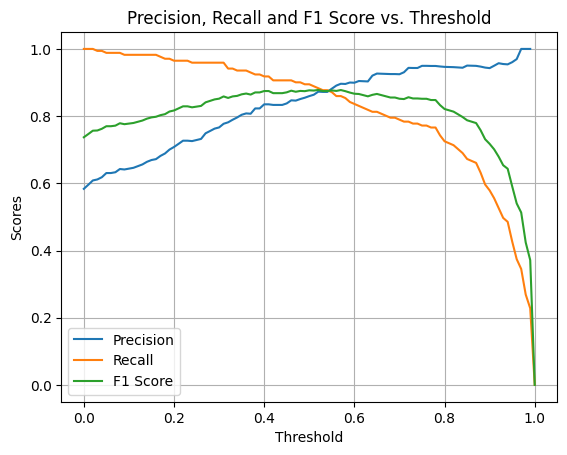

In [119]:
plt.Figure(figsize=(4, 4))
plt.plot(df_scores.threshold, df_scores.Precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.Recall, label='Recall')
plt.plot(df_scores.threshold, df_scores.F1, label='F1 Score')
plt.title('Precision, Recall and F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
            
    y_train = df_train.converted.values
    y_val = df_val.converted.values
            
    del df_train['converted']
    del df_val['converted']
            
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
            
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

average_auc = np.mean(scores)
std_auc = np.std(scores)

print(f'Average AUC across 5 folds: {average_auc:.3f}')
print(f'Standard deviation of AUC across 5 folds: {std_auc:.3f}')

Average AUC across 5 folds: 0.822
Standard deviation of AUC across 5 folds: 0.036


In [127]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        del df_train['converted']
        del df_val['converted']
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
    
    print('C=%.3f %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=0.000 0.822 +- 0.036
C=0.001 0.822 +- 0.036
C=1.000 0.822 +- 0.036
